So my approach was completely wrong...

I'll try again. You'll see how differently I handle data preprocessing here.

In [122]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from scipy.stats import skewnorm
from scipy.optimize import curve_fit
import os

#allocating datasets and model to GPU for speed's sake
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## The Model

In [123]:
class TripleOutputBNN(nn.Module):
    def __init__(self, no_of_neurones, dropout_prob):
        super(TripleOutputBNN, self).__init__()
        self.shared_layer = nn.Sequential( #this is the input layer
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=3, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        self.output_layer_y0 = nn.Sequential( #this is the output layer for y0
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=113)
        )
        self.output_layer_y1 = nn.Sequential( #this is the output layer for y1
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=113)
        )
        self.output_layer_y2 = nn.Sequential( #this is the output layer for y2
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=113)
        )


    def forward(self, x): #this is the forward pass, run automatically when you call the model
        shared = self.shared_layer(x)
        y0 = self.output_layer_y0(shared)
        y1 = self.output_layer_y1(shared)
        y2 = self.output_layer_y2(shared)
        return y0, y1, y2

In [124]:
def initialise_model(no_of_neurones: int, dropout_prob: float, lr: float = 0.01) -> tuple:
    """
    Initialise the DualOutputBNN model with its loss functions and optimizer.

    Parameters:
    - no_of_neurones (int): Number of neurons in the hidden layer.
    - dropout_prob (float): Dropout probability.
    - lr (float): Learning rate for the optimizer. Default is 0.01.

    Returns:
    - A tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    """

    model = TripleOutputBNN(no_of_neurones, dropout_prob).to(device)

    mse_loss = nn.MSELoss().to(device)
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
    kl_weight = 0.01

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    return model, mse_loss, kl_loss, kl_weight, optimizer

In [125]:
def train_model(model_attributes, input_train, output_train, epochs: int):
    """
    Train a Bayesian Neural Network model for a specified number of epochs.

    Parameters:
    - model_attributes: A tuple containing the model, loss functions, kl_weight, and optimizer.
    - input_train (torch.Tensor): Input tensor for the training data of lg_st_mass, lg_dst_st_mass.
    - output_train (torch.Tensor): Target tensor for the training data of n, f, r.
    - epochs (int): Number of epochs to train the model.

    Returns:
    - model (torch.nn.Sequential): The trained neural network model.

    Ensures that training data and model are on the same device for efficiency.
    """

    model, mse_loss, kl_loss, kl_weight, optimizer = model_attributes
    model = model.train()

    for _ in range(epochs): 
        n_pred, f_pred, r_pred = model(input_train)

        n_mse = mse_loss(torch.unsqueeze(torch.Tensor(n_pred), dim = 2), torch.unsqueeze(torch.Tensor(output_train[:,0]), dim=2))
        f_mse = mse_loss(torch.unsqueeze(torch.Tensor(f_pred), dim = 2), torch.unsqueeze(torch.Tensor(output_train[:,1]), dim=2))
        r_mse = mse_loss(torch.unsqueeze(torch.Tensor(r_pred), dim = 2), torch.unsqueeze(torch.Tensor(output_train[:,2]), dim=2))

        kl = kl_loss(model)
        n_cost, f_cost, r_cost = n_mse + kl_weight * kl, f_mse + kl_weight * kl, r_mse + kl_weight * kl
        cost = n_cost + f_cost + r_cost

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    print(f"- Cost: {cost.item():.3f}")

    return model

In [126]:
def test_model(model, input_test):
    """
    Test a Bayesian Neural Network model to produce predictions along with mean and standard deviation.

    Parameters:
    - model (torch.nn.Sequential): The trained neural network model.
    - func (callable): The target function to compare against the model's predictions.

    Returns:
    - mean_model_results (numpy.ndarray): Array of mean predictions from the model.
    - std_model_results (numpy.ndarray): Array of standard deviations of the predictions.
    - inpt_test (torch.Tensor): Testing dataset inputs.
    - outpt_test (torch.Tensor): Testing dataset targets.

    The testing data is moved to the device specified by the global `device` variable.
    """

    #producing predictions of model of testing data, as well as mean and standard deviation of predictions
    model = model.eval().cpu()
    input_test = input_test.cpu()

    n_pred = np.array([model(input_test)[0].detach().numpy() for _ in range(500)]).T
    f_pred = np.array([model(input_test)[1].detach().numpy() for _ in range(500)]).T
    r_pred = np.array([model(input_test)[2].detach().numpy() for _ in range(500)]).T

    mean_n_results, std_n_results = np.array([np.mean(n_pred[i]) for i in range(n_pred.shape[0])]), np.array([np.std(n_pred[i]) for i in range(n_pred.shape[0])])
    mean_f_results, std_f_results = np.array([np.mean(f_pred[i]) for i in range(f_pred.shape[0])]), np.array([np.std(f_pred[i]) for i in range(f_pred.shape[0])])
    mean_r_results, std_r_results = np.array([np.mean(r_pred[i]) for i in range(r_pred.shape[0])]), np.array([np.std(r_pred[i]) for i in range(r_pred.shape[0])])

    return mean_n_results, std_n_results, mean_f_results, std_f_results, mean_r_results, std_r_results

## The Data Processing

In [127]:
def read_params(filename: str, filepath: str = '../../data/radiative_transfer/input/'):
    """
    Reads parameters from a specified file and returns them as a dictionary.

    The function reads a text file where each line contains a parameter in the format:
    `key = value # optional comment`. The function parses these lines to extract the keys 
    and values, ignoring any text following a '#' as a comment.

    Parameters:
    - file (str, optional): The path to the file containing the parameters. 
    Default is '../../data/radiative_transfer/input/parameters.txt'.

    Returns:
    - dict: A dictionary where each key-value pair corresponds to a parameter 
    and its respective value. If a line contains a comma-separated list of values, 
    they are converted to a NumPy array. If the value is a single number (except for 
    the 'theta' parameter), it is converted to a float.

    Note:
    - This function assumes that each parameter is defined only once in the file.
    - The function is designed to handle special cases where the value is a list 
    (converted to a NumPy array) or a single float. The exception is the 'theta' 
    parameter, which is always treated as a NumPy array.
    """

    lines = open(filepath+filename, 'r').readlines()

    keys = []
    values = []
    for i in range(len(lines)):

        line_i = lines[i]
        line1 = line_i.split('\n')[0]
        line2 = line1.split('#')[0]
        line3 = line2.split('=')
        line4 = []
        for j in range(len(line3)):
            line4.append( line3[j].strip(' ') )

        if len(line4) == 2:
            keys.append(line4[0])
            line5 = line4[1].split(', ')
            line5 = np.array(line5).astype(float)
            if len(line5) == 1 and line4[0]!='theta':
                line5 = line5[0]
            values.append(line5)

    table = dict(zip(keys, values) )
    return table

In [128]:
def read_h5_file(filename: str, data, thetas, log_mstar, log_mdust_over_mstar, filepath: str = '../../data/radiative_transfer/output/'):
    """
    Reads HDF5 files and compiles data into a single DataFrame with additional parameters.

    Parameters:
    - filename (str): The name of the HDF5 file to be read.
    - thetas (array-like): An array of viewing angles corresponding to each entry in the HDF5 file.
    - log_mstar (float): Logarithmic value of stellar mass.
    - log_mdust_over_mstar (float): Logarithmic value of the dust mass over stellar mass ratio.
    - filepath (str, optional): Path to the directory containing the HDF5 file. Defaults to '../../data/radiative_transfer/output/'.

    Returns:
    - pd.DataFrame: A DataFrame containing wavelength, flux, half-light radius, Sersic index, viewing angle, logarithm of stellar mass, and logarithm of dust mass over stellar mass ratio.

    This function iterates over keys in the HDF5 file, extracts relevant data, and compiles it into a comprehensive DataFrame, adding constant parameters for stellar mass and dust mass ratios.
    """

    filepath += filename 
    print(filepath)

    # Finding hdf keys
    hdf_keys = np.array([])
    with pd.HDFStore(filepath, 'r') as hdf:
        hdf_keys = np.append(hdf_keys, hdf.keys())

    for i in range(len(hdf_keys)):

        table = pd.read_hdf(filepath, hdf_keys[i]) # Face-on view
        wvl = table['wvl'].to_numpy(dtype=np.float64) # rest-frame wavelength [micron]
        flux = table['flux'].to_numpy(dtype=np.float64) # flux [W/m^2]
        r = table['r'].to_numpy(dtype=np.float64) # half-light radius [kpc]
        n = table['n'].to_numpy(dtype=np.float64) # Sersic index

        data = pd.concat([data, pd.DataFrame({"log_mstar": log_mstar, "log_mdust_over_mstar": log_mdust_over_mstar, "theta": thetas[i], "n":[n], "flux":[flux], "r":[r]})], ignore_index=True)

    return wvl, data.reset_index(drop=True)

In [129]:
def read_parameter_files(filenames: list, filepath: str = "../../data/radiative_transfer/input/"):
    """
    Reads multiple parameter files and extracts key information.

    Parameters:
    - filenames (list): A list of filenames for the parameter files to be read.
    - filepath (str, optional): Path to the directory containing the parameter files. Defaults to "../../data/radiative_transfer/input/".

    Returns:
    - tuple: A tuple containing three arrays - list_log_mstar, list_log_mdust_over_mstar, and list_theta. 
        - list_log_mstar (numpy.ndarray): Array of logarithmic stellar mass values.
        - list_log_mdust_over_mstar (numpy.ndarray): Array of logarithmic dust mass over stellar mass ratio values.
        - list_theta (numpy.ndarray): Array of viewing angles.

    The function iterates over each file, reads its parameters, and compiles key data into arrays for further processing.
    """

    list_log_mstar = np.array([])
    list_log_mdust = np.array([])
    list_theta = np.array([])

    for filename in filenames:
        table = read_params(filename, filepath)
        list_log_mstar = np.append(list_log_mstar, table['logMstar'])
        list_log_mdust = np.append(list_log_mdust, table['logMdust'])
        list_theta = np.append(list_theta, table['theta'])

    list_log_mdust_over_mstar = list_log_mdust - list_log_mstar

    return list_log_mstar, list_log_mdust_over_mstar, list_theta


In [130]:
def generate_dataset(data, params, files):
    """
    Generates a dataset by reading parameters and HDF5 files, and compiling them into a DataFrame.

    This function iterates over given parameter files and HDF5 files. For each parameter file, it reads the stellar mass, dust mass, and viewing angles. Then, for each HDF5 file, it compiles data related to flux, half-light radius, and Sersic index along with the parameters into a DataFrame.

    Parameters:
    - df (pd.DataFrame): An empty DataFrame or a DataFrame with predefined columns to which the data will be appended. Expected columns are ["log_mstar", "log_mdust_over_mstar", "theta", "n", "flux", "r"].
    - params (list): A list of file names for the parameter files. These files contain values for log stellar mass, log dust/stellar mass ratio, and viewing angles.
    - files (list): A list of HDF5 file names. These files contain data for flux, half-light radius, and Sersic index.

    Returns:
    - pd.DataFrame: A DataFrame containing combined data from parameter files and HDF5 files, with columns for log stellar mass, log dust/stellar mass ratio, viewing angle, Sersic index, flux, and half-light radius.

    Note:
    - The function `read_parameter_files` is used to read the parameter files, and `read_h5_file` is used to read the HDF5 files and append their data to the DataFrame.
    - The function assumes that the length of 'params' and 'files' is the same, and each parameter file corresponds to a HDF5 file.
    """

    list_log_mstar, list_log_mdust_over_mstar, list_theta = read_parameter_files(params)

    for i in range(len(files)):
        wavelength, data = read_h5_file(files[i], data, np.sin(list_theta), list_log_mstar[i], list_log_mdust_over_mstar[i])

    return wavelength, data

In [131]:
#obtaining logs of stellar mass, and ratio of dust to stellar mass
parameter_files = [file for file in os.listdir("../../data/radiative_transfer/input/") if file.startswith("parameters")]
h5_files = [file for file in os.listdir("../../data/radiative_transfer/output/") if file.startswith("data")]

In [132]:
wavelength, h5_data = generate_dataset(pd.DataFrame(columns=["log_mstar", "log_mdust_over_mstar", "theta", "n", "flux", "r"]), parameter_files, h5_files)
h5_data

../../data/radiative_transfer/output/data1.h5
../../data/radiative_transfer/output/data2.h5
../../data/radiative_transfer/output/data3.h5


../../data/radiative_transfer/output/data4.h5
../../data/radiative_transfer/output/data5.h5
../../data/radiative_transfer/output/data6.h5


,log_mstar,log_mdust_over_mstar,theta,n,flux,r
0,11.32,-2.74,0.000000,"[0.2000007292673196, 0.20000000005066382, 0.20...","[6.501817484772457e-12, 2.803091827610573e-11,...","[8.836515150340569, 8.836515150340569, 8.83651..."
1,11.32,-2.74,-0.178593,"[0.20000000544425142, 0.20000000000020654, 0.2...","[6.4466429084170395e-12, 2.7748459723856662e-1...","[9.68620248039904, 9.379569621745969, 8.943801..."
2,11.32,-2.74,0.984980,"[0.20000000146611688, 0.2000000004568411, 0.20...","[5.515552922411008e-12, 2.3455318268139408e-11...","[11.142284556552317, 11.1403967380588, 10.9592..."
3,11.32,-2.74,0.940491,"[0.20000001469323, 0.2000000130524198, 0.20000...","[5.246167290273239e-12, 2.24901439817031e-11, ...","[11.462289154761372, 11.26065811372605, 10.922..."
4,11.32,-2.74,0.160195,"[0.20000000776697846, 0.2000000043601083, 0.20...","[4.986853732036401e-12, 2.1278108468096852e-11...","[11.280985295980038, 11.166541361898771, 11.08..."
...,...,...,...,...,...,...
115,11.00,-3.25,0.636396,"[0.20000000064438161, 0.200000006537631, 0.200...","[5.307616937707205e-12, 2.4068326185422138e-11...","[8.963317736572487, 8.50645836266751, 8.199363..."
116,11.00,-3.25,-0.689942,"[0.20000000197656176, 0.2000000000271405, 0.20...","[5.241944199752592e-12, 2.375376125980818e-11,...","[9.070144105651742, 8.620617694451553, 8.30701..."
117,11.00,-3.25,0.759798,"[0.20000000008991323, 0.20000066243584425, 0.2...","[5.089481414692804e-12, 2.311341074149899e-11,...","[9.064226249948268, 8.823039027870434, 8.29629..."
118,11.00,-3.25,-0.833048,"[0.20000000007468507, 0.20000004333460603, 0.2...","[5.017208456263936e-12, 2.26820185382521e-11, ...","[9.21028050161192, 8.752559122839797, 8.359318..."


Okay, we now have an idea of what flux, half-radius, and sersic index look like as functions of wavelength.

Now we just need to find the best way to model them.


In [133]:
skewed_normal = lambda x, amplitude, mean, std, alpha: amplitude * skewnorm.pdf(x, alpha, loc=mean, scale=std)
inverse_power_law_decay = lambda x, a, n, c: (a/np.power(x, n)) + c
normalise = lambda x: (x - np.mean(x)) / np.std(x)

def fit_to_data(x, y, range, func):
    x, y = x[(x>range[0]) & (x<range[1])], y[(x>range[0]) & (x<range[1])]
    #produce an array of initial guesses that are compatible for both functions
    if func == skewed_normal:
        p0 = [np.max(y), np.mean(x), np.std(x), 5]
    elif func == inverse_power_law_decay:
        p0 = [np.max(y), 2, 0]

    popt, _ = curve_fit(func, x, y, p0=p0, maxfev=10000)

    return popt

test_df = pd.DataFrame({"wavelength":wavelength, "n":h5_data["n"][30], "f":h5_data["flux"][30], "r":h5_data["r"][30]})
test_df.to_csv("../../data/radiative_transfer/output/test.csv", index=False)


In [134]:
#split h5_data into training and testing sets
train, test = train_test_split(h5_data, test_size=0.2, random_state=42)
train, test = train.reset_index(drop=True), test.reset_index(drop=True)

train_inputs, train_outputs = train[["log_mstar", "log_mdust_over_mstar", "theta"]], train[["n", "flux", "r"]]
test_inputs, test_outputs = test[["log_mstar", "log_mdust_over_mstar", "theta"]], test[["n", "flux", "r"]]

#convert training and testing data into numpy arrays
train_inputs, test_inputs = train_inputs.to_numpy(), test_inputs.to_numpy()
train_inputs, test_inputs = torch.Tensor(train_inputs).to(device), torch.Tensor(test_inputs).to(device)

def convert_to_tensor(data):
    data = data.applymap(np.array)
    stacked_input_arrays = np.stack(data.apply(lambda row: np.stack(row, axis=0), axis=1).to_numpy())
    data = torch.Tensor(stacked_input_arrays).to(device)

    return data

train_outputs, test_outputs = convert_to_tensor(train_outputs).to(device), convert_to_tensor(test_outputs).to(device)

torch.Size([96, 3, 113]) torch.Size([24, 3, 113])


In [135]:
#initialise, train, and test the model
model_attributes = initialise_model(1000, 0.3)
model = train_model(model_attributes, train_inputs, train_outputs, 1000)
mean_n_results, std_n_results, mean_f_results, std_f_results, mean_r_results, std_r_results = test_model(model, test_inputs)
test_outputs = test_outputs.cpu().numpy()

n_pred: torch.Size([96, 113]), f_pred: torch.Size([96, 113]), r_pred: torch.Size([96, 113])
- Cost: 1.997


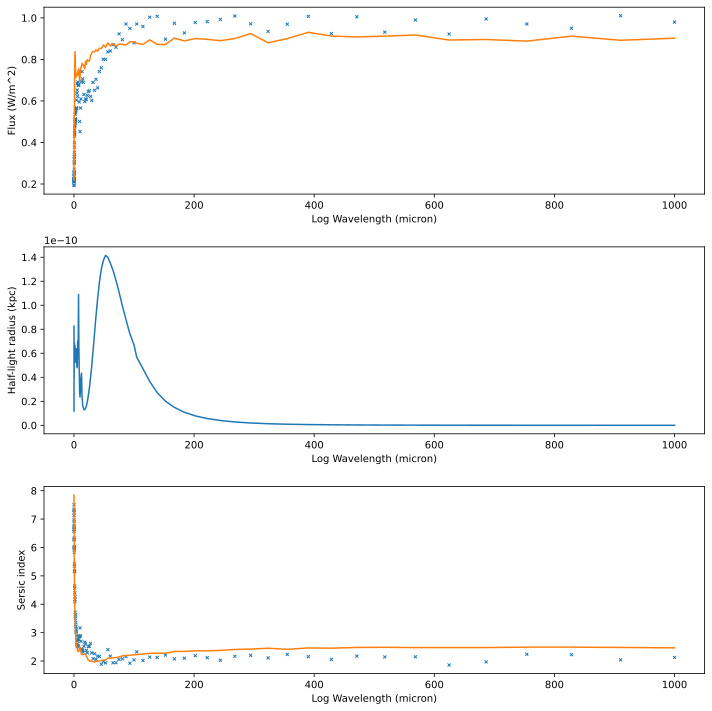

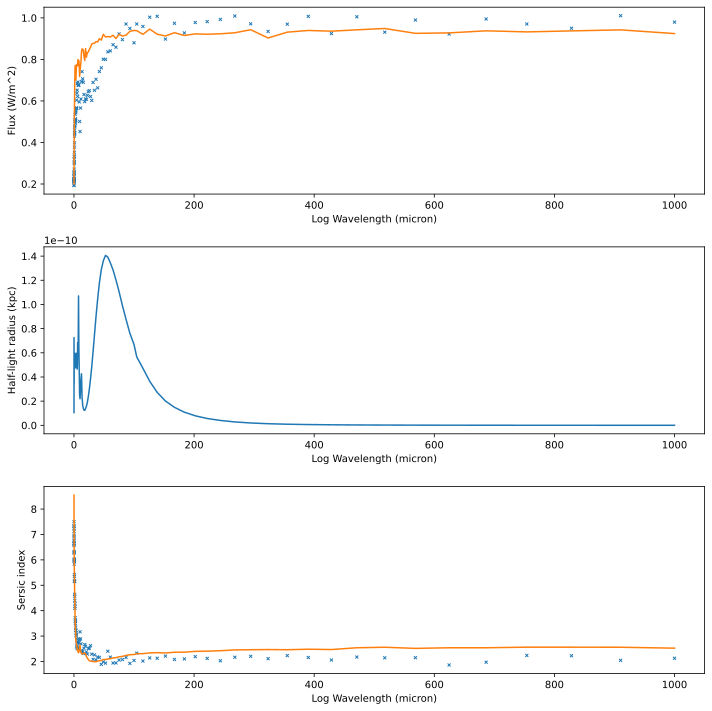

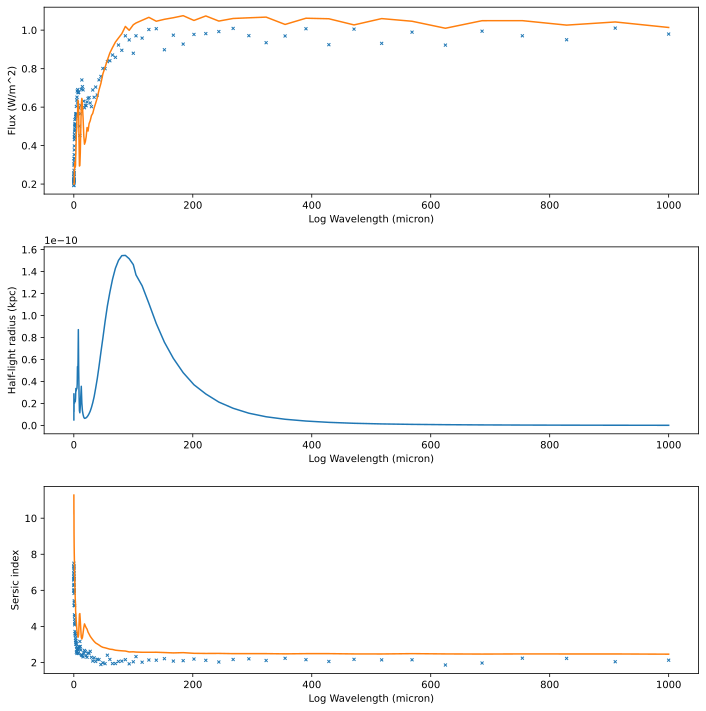

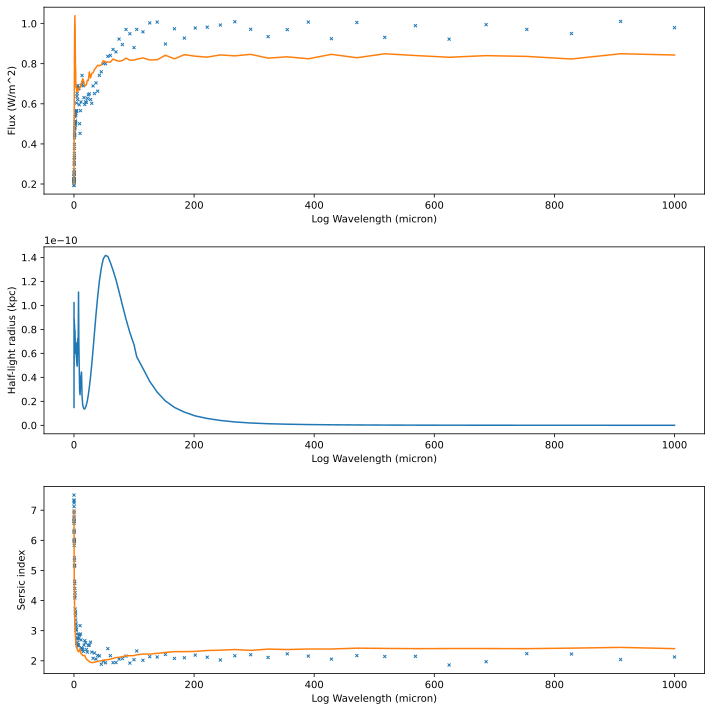

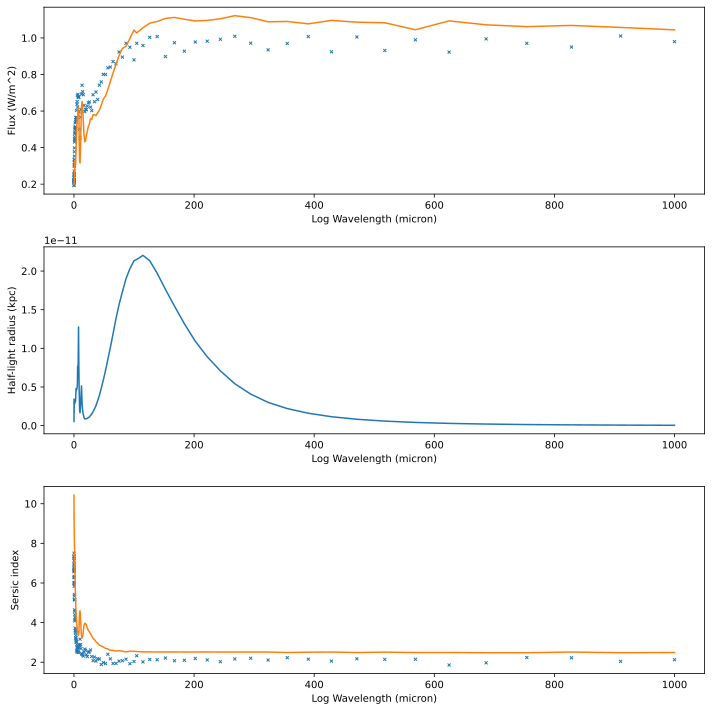

In [136]:
#plot the predicted sersic index, flux, and half-radius against wavelength on separate axes, but same figure: for the first 5 galaxies. plot the actual data, too
for i in range(5):
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    axs[0].plot(wavelength, mean_n_results, label=f"Galaxy {i}", ls="None", marker="x", markersize=3)
    axs[0].plot(wavelength, test_outputs[i, 0], label=f"Galaxy {i}")
    axs[0].set_xlabel("Log Wavelength (micron)")
    axs[0].set_ylabel("Flux (W/m^2)")
    # axs[0].set_xscale("log")

    # axs[1].plot(wavelength, mean_f_results, label=f"Galaxy {i}", ls="None", marker="x", markersize=3)
    axs[1].plot(wavelength, test_outputs[i, 1], label=f"Galaxy {i}")
    axs[1].set_xlabel("Log Wavelength (micron)")
    axs[1].set_ylabel("Half-light radius (kpc)")
    # axs[1].set_xscale("log")

    axs[2].plot(wavelength, mean_r_results, label=f"Galaxy {i}", ls="None", marker="x", markersize=3)
    axs[2].plot(wavelength, test_outputs[i, 2], label=f"Galaxy {i}")
    axs[2].set_xlabel("Log Wavelength (micron)")
    axs[2].set_ylabel("Sersic index")
    # axs[2].set_xscale("log")
    
    plt.tight_layout()
    plt.show()
    plt.close()